In [1]:
import sys
home = '/home/nina/CopulaGP/'
sys.path.insert(0, home)

import utils
from train import conf
import glob
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch

import MI
import tqdm
import bvcopula
from vine import CVine

In [16]:
animal = 'ST260'
day_name = 'Day1'
exp_pref = f'{animal}_{day_name}'
path_models = f"{conf.path2outputs}/{exp_pref}_gnT"
path_models

'/home/nina/outputs/ST260_Day1_gnT'

In [17]:
list_files = glob.glob(f"{path_models}/models_*.pkl")

In [18]:
with open(f"{path_models}/models_layer0.pkl","rb") as f:
    results = pkl.load(f)
NN = len(results)+1
WAICs = np.zeros((NN,NN))
WAICs[0,1:] = [a[3] for a in results]
for layer in range(1,len(results)):
    with open(f"{path_models}/models_layer{layer}.pkl","rb") as f:
        res = pkl.load(f)
    WAICs[layer,(layer+1):] = [a[3] for a in res]

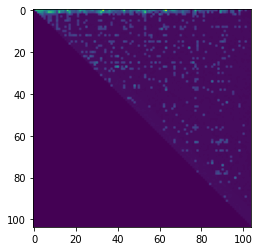

In [19]:
plt.imshow(WAICs[:])

In [20]:
device = "cuda:0"

# create linspace
N_points = 50
# train_x = torch.linspace(0,1,N_points).to(device)

#real
X,Y = utils.standard_loader(f"{conf.path2data}/{exp_pref}_standard.pkl")
# N_points=X.shape[0]
N_points = 200
train_x = torch.tensor(X, device=device).float()
train_x = train_x[torch.randperm(train_x.numel())[:N_points]]

copula_layers, likelihood_layers, fs_layers = [], [], []
for layer in tqdm.tqdm(range(0,NN-1)):
    copulas, liks, fs = [], [], []
    with open(f"{path_models}/models_layer{layer}.pkl","rb") as f:
        results = pkl.load(f)
    out_dir = f'{path_models}/layer{layer}'
    for n,res in enumerate(results):
        if res[1]!='Independence':
            likelihoods = res[0]
            weights_file = f"{out_dir}/model_{exp_pref}_{layer}-{layer+n+1}.pth"
            model = utils.get_model(weights_file, likelihoods, device)
            liks.append(model.likelihood)
            with torch.no_grad():
                f = model(train_x).mean
                copula = model.likelihood.get_copula(f)
                copulas.append(copula)
                fs.append(f)
        else:
            copulas.append(bvcopula.MixtureCopula(torch.empty(1,0,device=device),
                    torch.ones(1,N_points,device=device),
                    [bvcopula.IndependenceCopula]))
            fs.append(None)
            liks.append([bvcopula.IndependenceCopula_Likelihood()])
#     else:
#         for n in range(NN-1-layer):
#             copulas.append(bvcopula.MixtureCopula(torch.empty(1,0,device=device),
#                         torch.ones(1,N_points,device=device),
#                         [bvcopula.IndependenceCopula]))
#             fs.append(None)
#             liks.append([bvcopula.IndependenceCopula_Likelihood()])
    copula_layers.append(copulas)
    likelihood_layers.append(liks)
    fs_layers.append(fs)

100%|██████████| 103/103 [00:07<00:00, 13.94it/s]


In [21]:
# [len(copula_layers[i]) for i in range(108)]
c, c1 = 0, 0
for layer in copula_layers:
    for copulas in layer:
        c+= 1
        if len(copulas.copulas)==1:
            if copulas.copulas[0].__name__ == "IndependenceCopula":
                c1 += 1
print(c1,c,c1/c,c-c1)

4705 5356 0.878454070201643 651


In [8]:
# import time
# X,Y = utils.standard_loader(f"{conf.path2data}/{exp_pref}_standard.pkl")
# indep = bvcopula.MixtureCopula(torch.empty(1,0,device=device),
#                     torch.ones(1,1,device=device),
#                     [bvcopula.IndependenceCopula])
# N = Y.shape[-1]
# # device = torch.device('cpu')
# data_layers = [torch.tensor(Y).float().to(device)]
# copula_layers = []
# t0 = time.time()
# for m in range(0,N-1):
#     copulas, layer = [], []
#     for n in tqdm.tqdm(range(1,N-m)):
#         samples = data_layers[-1][...,[n,0]]
#         likelihood = likelihood_layers[m][n-1]
#         f0 = fs_layers[m][n-1]
#         if f0 is None:
#             assert likelihood[0].name=='Independence'
#             copulas.append(indep)
#             layer.append(samples[:,0])
#         else:
#             f0 = f0.mean(axis=-1).unsqueeze(-1)
# #             copula0 = likelihood(f0)
#             copula = likelihood.fit(samples,f0,n_epoch=500)
# #             print(f"{m},{n+m}: {(copula0.theta-copula.theta).mean().cpu()}")
#             copulas.append(copula)
#             layer.append(copula.ccdf(samples.unsqueeze(-2)).squeeze())
#     data_layers.append(torch.stack(layer,dim=-1))
#     copula_layers.append(copulas)
# t1= time.time()
# print(f"{(t1-t0)//60}")

In [22]:
# train_x = torch.ones(1,device=device)
vine = CVine(copula_layers,train_x,device=device)

In [23]:
# with open(f"{home}/results/D1UxFU_vine.pkl","wb") as f:
#     pkl.dump([copula_layers,vine],f)
-18.64 -18.36 -20.93

-32.05

In [24]:
h = []
Ns = 104-np.array([0,10,20,30,40,50,60,70,80,90,100,101,102,103,104])
# h.append(H[0])
for n in tqdm.tqdm(Ns[:-1]):
    layers = [[copula_layers[i][j] for j in range(n-1-i)] for i in range(n-1)]
    vineR = CVine(layers,train_x,device=device)
    entropy = vineR.entropy(sem_tol=0.1, mc_size=200, v=True)
    h.append(entropy.cpu().numpy())
    print(h[-1].mean())
h.append(np.zeros_like(h[-1]))
with open(f"{home}/results/HYgX_subpop_D1_gnT.pkl","wb") as f:
    pkl.dump([Ns,train_x.cpu().numpy(),h],f)

  0%|          | 0/14 [00:00<?, ?it/s]

tensor(7.8797, device='cuda:0')
tensor(5.3799, device='cuda:0')
tensor(4.2787, device='cuda:0')
tensor(3.6166, device='cuda:0')
tensor(3.2196, device='cuda:0')
tensor(2.8964, device='cuda:0')
tensor(2.6935, device='cuda:0')
tensor(2.5029, device='cuda:0')
tensor(2.3626, device='cuda:0')
tensor(2.2624, device='cuda:0')
tensor(2.1594, device='cuda:0')
tensor(2.0519, device='cuda:0')
tensor(1.9783, device='cuda:0')
tensor(1.8943, device='cuda:0')
tensor(1.8250, device='cuda:0')
tensor(1.7707, device='cuda:0')
tensor(1.7151, device='cuda:0')
tensor(1.6629, device='cuda:0')
tensor(1.6173, device='cuda:0')
tensor(1.5765, device='cuda:0')
tensor(1.5366, device='cuda:0')
tensor(1.5005, device='cuda:0')
tensor(1.4657, device='cuda:0')
tensor(1.4352, device='cuda:0')
tensor(1.4062, device='cuda:0')
tensor(1.3761, device='cuda:0')
tensor(1.3505, device='cuda:0')
tensor(1.3272, device='cuda:0')
tensor(1.3025, device='cuda:0')
tensor(1.2807, device='cuda:0')
tensor(1.2604, device='cuda:0')
tensor(1

  7%|▋         | 1/14 [41:08<8:54:53, 2468.72s/it]

tensor(0.9993, device='cuda:0')
-20.927656
tensor(7.6264, device='cuda:0')
tensor(5.2279, device='cuda:0')
tensor(4.2061, device='cuda:0')
tensor(3.5835, device='cuda:0')
tensor(3.1670, device='cuda:0')
tensor(2.9169, device='cuda:0')
tensor(2.6965, device='cuda:0')
tensor(2.5030, device='cuda:0')
tensor(2.3746, device='cuda:0')
tensor(2.2563, device='cuda:0')
tensor(2.1351, device='cuda:0')
tensor(2.0476, device='cuda:0')
tensor(1.9692, device='cuda:0')
tensor(1.8937, device='cuda:0')
tensor(1.8212, device='cuda:0')
tensor(1.7680, device='cuda:0')
tensor(1.7142, device='cuda:0')
tensor(1.6635, device='cuda:0')
tensor(1.6185, device='cuda:0')
tensor(1.5754, device='cuda:0')
tensor(1.5358, device='cuda:0')
tensor(1.5007, device='cuda:0')
tensor(1.4676, device='cuda:0')
tensor(1.4372, device='cuda:0')
tensor(1.4049, device='cuda:0')
tensor(1.3769, device='cuda:0')
tensor(1.3487, device='cuda:0')
tensor(1.3230, device='cuda:0')
tensor(1.3014, device='cuda:0')
tensor(1.2771, device='cuda:0

 14%|█▍        | 2/14 [1:17:24<7:56:09, 2380.76s/it]

-20.626406
tensor(7.8703, device='cuda:0')
tensor(5.2484, device='cuda:0')
tensor(4.1753, device='cuda:0')
tensor(3.6289, device='cuda:0')
tensor(3.2151, device='cuda:0')
tensor(2.9368, device='cuda:0')
tensor(2.6938, device='cuda:0')
tensor(2.5021, device='cuda:0')
tensor(2.3545, device='cuda:0')
tensor(2.2249, device='cuda:0')
tensor(2.1174, device='cuda:0')
tensor(2.0259, device='cuda:0')
tensor(1.9394, device='cuda:0')
tensor(1.8737, device='cuda:0')
tensor(1.8112, device='cuda:0')
tensor(1.7561, device='cuda:0')
tensor(1.7035, device='cuda:0')
tensor(1.6484, device='cuda:0')
tensor(1.6030, device='cuda:0')
tensor(1.5638, device='cuda:0')
tensor(1.5253, device='cuda:0')
tensor(1.4850, device='cuda:0')
tensor(1.4537, device='cuda:0')
tensor(1.4202, device='cuda:0')
tensor(1.3872, device='cuda:0')
tensor(1.3639, device='cuda:0')
tensor(1.3370, device='cuda:0')
tensor(1.3144, device='cuda:0')
tensor(1.2980, device='cuda:0')
tensor(1.2744, device='cuda:0')
tensor(1.2552, device='cuda:0

 21%|██▏       | 3/14 [1:47:42<6:45:31, 2211.97s/it]

-19.681751
tensor(7.4864, device='cuda:0')
tensor(5.3195, device='cuda:0')
tensor(4.1719, device='cuda:0')
tensor(3.5429, device='cuda:0')
tensor(3.1303, device='cuda:0')
tensor(2.8572, device='cuda:0')
tensor(2.6352, device='cuda:0')
tensor(2.4660, device='cuda:0')
tensor(2.3113, device='cuda:0')
tensor(2.1794, device='cuda:0')
tensor(2.0798, device='cuda:0')
tensor(1.9961, device='cuda:0')
tensor(1.9140, device='cuda:0')
tensor(1.8399, device='cuda:0')
tensor(1.7797, device='cuda:0')
tensor(1.7259, device='cuda:0')
tensor(1.6770, device='cuda:0')
tensor(1.6265, device='cuda:0')
tensor(1.5837, device='cuda:0')
tensor(1.5449, device='cuda:0')
tensor(1.5096, device='cuda:0')
tensor(1.4743, device='cuda:0')
tensor(1.4433, device='cuda:0')
tensor(1.4115, device='cuda:0')
tensor(1.3823, device='cuda:0')
tensor(1.3541, device='cuda:0')
tensor(1.3249, device='cuda:0')
tensor(1.3004, device='cuda:0')
tensor(1.2798, device='cuda:0')
tensor(1.2606, device='cuda:0')
tensor(1.2393, device='cuda:0

 29%|██▊       | 4/14 [2:12:08<5:31:22, 1988.21s/it]

-18.658607
tensor(6.7140, device='cuda:0')
tensor(4.7144, device='cuda:0')
tensor(3.8515, device='cuda:0')
tensor(3.3289, device='cuda:0')
tensor(2.9613, device='cuda:0')
tensor(2.6981, device='cuda:0')
tensor(2.4894, device='cuda:0')
tensor(2.3270, device='cuda:0')
tensor(2.1934, device='cuda:0')
tensor(2.0869, device='cuda:0')
tensor(1.9851, device='cuda:0')
tensor(1.8959, device='cuda:0')
tensor(1.8099, device='cuda:0')
tensor(1.7424, device='cuda:0')
tensor(1.6828, device='cuda:0')
tensor(1.6256, device='cuda:0')
tensor(1.5718, device='cuda:0')
tensor(1.5248, device='cuda:0')
tensor(1.4846, device='cuda:0')
tensor(1.4458, device='cuda:0')
tensor(1.4075, device='cuda:0')
tensor(1.3798, device='cuda:0')
tensor(1.3524, device='cuda:0')
tensor(1.3284, device='cuda:0')
tensor(1.3013, device='cuda:0')
tensor(1.2730, device='cuda:0')
tensor(1.2461, device='cuda:0')
tensor(1.2216, device='cuda:0')
tensor(1.1967, device='cuda:0')
tensor(1.1761, device='cuda:0')
tensor(1.1570, device='cuda:0

 36%|███▌      | 5/14 [2:30:00<4:17:01, 1713.46s/it]

-17.653183
tensor(6.3977, device='cuda:0')
tensor(4.4141, device='cuda:0')
tensor(3.5518, device='cuda:0')
tensor(3.1074, device='cuda:0')
tensor(2.7846, device='cuda:0')
tensor(2.5167, device='cuda:0')
tensor(2.3437, device='cuda:0')
tensor(2.1921, device='cuda:0')
tensor(2.0564, device='cuda:0')
tensor(1.9451, device='cuda:0')
tensor(1.8594, device='cuda:0')
tensor(1.7754, device='cuda:0')
tensor(1.7008, device='cuda:0')
tensor(1.6258, device='cuda:0')
tensor(1.5653, device='cuda:0')
tensor(1.5124, device='cuda:0')
tensor(1.4618, device='cuda:0')
tensor(1.4192, device='cuda:0')
tensor(1.3792, device='cuda:0')
tensor(1.3426, device='cuda:0')
tensor(1.3120, device='cuda:0')
tensor(1.2818, device='cuda:0')
tensor(1.2550, device='cuda:0')
tensor(1.2294, device='cuda:0')
tensor(1.2054, device='cuda:0')
tensor(1.1796, device='cuda:0')
tensor(1.1608, device='cuda:0')
tensor(1.1374, device='cuda:0')
tensor(1.1175, device='cuda:0')
tensor(1.1002, device='cuda:0')
tensor(1.0821, device='cuda:0

 43%|████▎     | 6/14 [2:42:18<3:09:25, 1420.73s/it]

-16.358974
tensor(6.0330, device='cuda:0')
tensor(4.1055, device='cuda:0')
tensor(3.3262, device='cuda:0')
tensor(2.9022, device='cuda:0')
tensor(2.5646, device='cuda:0')
tensor(2.3233, device='cuda:0')
tensor(2.1427, device='cuda:0')
tensor(1.9973, device='cuda:0')
tensor(1.8913, device='cuda:0')
tensor(1.7887, device='cuda:0')
tensor(1.7041, device='cuda:0')
tensor(1.6203, device='cuda:0')
tensor(1.5519, device='cuda:0')
tensor(1.4928, device='cuda:0')
tensor(1.4467, device='cuda:0')
tensor(1.4018, device='cuda:0')
tensor(1.3586, device='cuda:0')
tensor(1.3186, device='cuda:0')
tensor(1.2848, device='cuda:0')
tensor(1.2490, device='cuda:0')
tensor(1.2240, device='cuda:0')
tensor(1.1970, device='cuda:0')
tensor(1.1699, device='cuda:0')
tensor(1.1470, device='cuda:0')
tensor(1.1215, device='cuda:0')
tensor(1.0992, device='cuda:0')
tensor(1.0783, device='cuda:0')
tensor(1.0596, device='cuda:0')
tensor(1.0396, device='cuda:0')
tensor(1.0230, device='cuda:0')
tensor(1.0047, device='cuda:0

 50%|█████     | 7/14 [2:50:12<2:12:37, 1136.75s/it]

-14.844182
tensor(5.5012, device='cuda:0')
tensor(3.7483, device='cuda:0')
tensor(3.0363, device='cuda:0')
tensor(2.5896, device='cuda:0')
tensor(2.3142, device='cuda:0')
tensor(2.1075, device='cuda:0')
tensor(1.9404, device='cuda:0')
tensor(1.7947, device='cuda:0')
tensor(1.6941, device='cuda:0')
tensor(1.6003, device='cuda:0')
tensor(1.5255, device='cuda:0')
tensor(1.4689, device='cuda:0')
tensor(1.4063, device='cuda:0')
tensor(1.3550, device='cuda:0')
tensor(1.3092, device='cuda:0')
tensor(1.2675, device='cuda:0')
tensor(1.2311, device='cuda:0')
tensor(1.1946, device='cuda:0')
tensor(1.1606, device='cuda:0')
tensor(1.1328, device='cuda:0')
tensor(1.1006, device='cuda:0')
tensor(1.0726, device='cuda:0')
tensor(1.0510, device='cuda:0')
tensor(1.0264, device='cuda:0')
tensor(1.0063, device='cuda:0')


 57%|█████▋    | 8/14 [2:54:37<1:27:31, 875.21s/it] 

-12.801824
tensor(4.4006, device='cuda:0')
tensor(3.0651, device='cuda:0')
tensor(2.4834, device='cuda:0')
tensor(2.1301, device='cuda:0')
tensor(1.9020, device='cuda:0')
tensor(1.7339, device='cuda:0')
tensor(1.6075, device='cuda:0')
tensor(1.5003, device='cuda:0')
tensor(1.4169, device='cuda:0')
tensor(1.3348, device='cuda:0')
tensor(1.2773, device='cuda:0')
tensor(1.2287, device='cuda:0')
tensor(1.1770, device='cuda:0')
tensor(1.1291, device='cuda:0')
tensor(1.0913, device='cuda:0')
tensor(1.0543, device='cuda:0')
tensor(1.0279, device='cuda:0')


 64%|██████▍   | 9/14 [2:56:32<53:55, 647.08s/it]  

tensor(0.9991, device='cuda:0')
-10.575994
tensor(3.3949, device='cuda:0')
tensor(2.3640, device='cuda:0')
tensor(1.8945, device='cuda:0')
tensor(1.6557, device='cuda:0')
tensor(1.4581, device='cuda:0')
tensor(1.3306, device='cuda:0')
tensor(1.2301, device='cuda:0')
tensor(1.1488, device='cuda:0')
tensor(1.0791, device='cuda:0')
tensor(1.0255, device='cuda:0')


 71%|███████▏  | 10/14 [2:57:05<30:51, 462.93s/it]

-7.9340672


 79%|███████▊  | 11/14 [2:57:06<16:12, 324.19s/it]

tensor(1.0627, device='cuda:0')
-1.9974049


100%|██████████| 14/14 [2:57:06<00:00, 759.02s/it]

-1.2284825
-0.5281324
0.0


In [ ]:
h = []
Ns = 109-np.array([0,10,20,30,40,50,60,70,80,90,100,101,102,103,104,105,106,107,108])
for n in tqdm.tqdm(Ns[:-1]):
    layers = [[copula_layers[i][j] for j in range(n-1-i)] for i in range(n-1)]
    vineR = CVine(layers,train_x,device=device)
    MI = vineR.stimMI(sR_mc_size=3000, s_mc_size=25, r_mc_size=5, sem_tol=0.05, v=True)
    h.append([MI[0].item(),MI[1].item(),MI[2].item(),MI[3].item()])
    print(h[-1])
h.append([0,0,0,0])
# with open(f"{home}/results/MI_subpop_D3C.pkl","wb") as f:
#     pkl.dump([Ns,train_x.cpu().numpy(),h],f)

In [ ]:
I = []
Ns = np.array([0,10,20,30,40,50,60,70,75,80,85,90,100,101,102,103,104,105,106,107,108])
for n in tqdm.tqdm(Ns):
    MI = vine.truncate(n).stimMI(sR_mc_size=1000, s_mc_size=25, r_mc_size=5, sem_tol=0.05, v=True)
    I.append([MI[0].item(),MI[1].item(),MI[2].item(),MI[3].item()])
    print(I[-1])
# with open(f"{home}/results/MI_trunc_D3C.pkl","wb") as f:
#     pkl.dump([Ns,train_x.cpu().numpy(),I],f)

In [ ]:
# %time Hrs = vine.entropy(sem_tol=.05, mc_size=4000, v=True)
# with open(f"{home}/results/HYgX_C.pkl","wb") as f:
#     pkl.dump(np.stack([train_x.cpu().numpy(),Hrs.cpu().numpy()]),f)
# plt.plot(Hrs.cpu().numpy())

In [ ]:
H = []
Ns = np.array([0,10,20,30,40,50,60,70,80,90,100,101,102,103,104])
for n in tqdm.tqdm(Ns):
    entropy = vine.truncate(n).entropy(sem_tol=0.1, mc_size=2000, v=False)
    H.append(entropy.cpu().numpy())
    print(H[-1].mean())
with open(f"{home}/results/HYgX_trunc_D1_gT.pkl","wb") as f:
    pkl.dump([Ns,train_x.cpu().numpy(),H],f)

In [ ]:
plt.plot(105-Ns[1:-1],[hh[0] for hh in h])

In [8]:
# now find MIs with MINE
X,Y = utils.standard_loader(f"{conf.path2data}/{exp_pref}_standard.pkl")
Ns = 109-np.array([0,10,20,30,40,50,60,70,80,90,100,101,102,103,104,105,106,107,108])
I = []
for n in tqdm.tqdm(Ns):
    I.append(MI.train_MINE(Y[...,:n],x=torch.tensor(X).float(),H=100,lr=0.01,device=device).item()/np.log(2))
    if n==Ns[0]:
        print(I)
with open(f"{home}/results/MI_subpop_MINE_D3C.pkl","wb") as f:
    pkl.dump([Ns,I],f)

  5%|▌         | 1/19 [00:40<12:05, 40.30s/it]

[0.8957348327316541]


100%|██████████| 19/19 [11:28<00:00, 36.25s/it]


In [34]:
# now find MIs with KSG
X,Y = utils.standard_loader(f"{conf.path2data}/{exp_pref}_unconditional.pkl")
Ns = 109-np.array([0,10,20,30,40,50,60,70,80,90,100,101,102,103,104,105,106,107,108])
I = []
for n in tqdm.tqdm(Ns):
    I.append(MI.BI_KSG(X.reshape((*X.shape,1)),Y[...,:n]))
    if n==Ns[0]:
        print(I)
with open(f"{home}/results/MI_subpop_KSG_U.pkl","wb") as f:
    pkl.dump([Ns,I],f)


  5%|▌         | 1/19 [05:43<1:43:04, 343.58s/it]

[(0.047278782656974314, 50.504160114699836)]



100%|██████████| 19/19 [28:29<00:00, 89.99s/it]


In [ ]:
# vine_trained = CVine(copula_layers,torch.ones(1),device=device)
# with open(f"{home}/results/vine_unconditional.pkl","wb") as f:
#     pkl.dump(vine_trained,f)
with open(f"{home}/results/vine_unconditional.pkl","rb") as f:
    vine_trained = pkl.load(f)
# %time Hr = vine_trained.entropy(sem_tol=.1, mc_size=4000, v=True)

In [ ]:
# Hrs = []
# Hr = []
# uncond_layers = vine_trained.layers
# for n in tqdm.tqdm(range(NN-1)):
#     vine = CVine(copula_layers[n:],train_x,device=device)
#     entropy = vine.entropy(sem_tol=0.1, mc_size=4000, v=False)
#     Hrs.append(-entropy.mean().item())
#     vine = CVine(uncond_layers[n:],torch.ones(1),device='cpu')
#     entropy = vine.entropy(sem_tol=0.1, mc_size=4000, v=False)
#     Hr.append(-entropy.mean().item())
#     print(Hrs[-1]-Hr[-1])

# Calculate MI(Y_i,X) with KSG
# X,Y = utils.standard_loader(f"{conf.path2data}/{exp_pref}_unconditional.pkl")
# singleH = np.empty((Y.shape[-1],2))
# for i in range(Y.shape[-1]):
#     singleH[i,:] = MI.BI_KSG(X.reshape((*X.shape,1)),Y[...,i].reshape((*X.shape,1)))
#     print(singleH[i,:])
# with open(f"{home}/results/singleH.pkl","wb") as f: #single variable BI_KSG:(MI,H(Y|X)) from uncond. data
#     pkl.dump(singleH,f)

# Calculate MI(Y_i,X) with MINE
# singleH = np.empty((Y.shape[-1]))
# for i in range(Y.shape[-1]):
#     singleH[i] = MI.train_MINE(Y[...,i].reshape((*X.shape,1)),x=torch.tensor(X).float(),
#                                H=100,lr=0.01,device=device).item()/np.log(2)
#     print(singleH[i])
# with open(f"{home}/results/singleMI.pkl","wb") as f: #single variable MINE MI from unconditional data
#     pkl.dump(singleH,f)

In [ ]:
# mem = (Hrs, Hr)
# with open(f"{home}/results/Hrs_and_Hr_experimental.pkl","wb") as f:
#     pkl.dump((Hrs,Hr),f)


In [ ]:
with open(f"{home}/results/singleH.pkl","rb") as f: #single variable BI_KSG:(MI,H(Y|X)) from standard data
    singleH = pkl.load(f)
with open(f"{home}/results/Hrs_and_Hr_top.pkl","rb") as f: # top layers of C-Vine
    (Hrs,Hr) = pkl.load(f)
np.array(Hrs)[0]

In [ ]:
singleH[:,0].shape

In [ ]:
n=3
layers = [[copula_layers[i][j] for j in range(n-i)] for i in range(n)]
layers

In [ ]:
HRS = []
for n in tqdm.tqdm(range(20)):
    layers = [[copula_layers[i][j] for j in range(n-i)] for i in range(n)]
    vine = CVine(layers,train_x,device=device)
    entropy = vine.entropy(sem_tol=0.1, mc_size=4000, v=False)
    HRS.append(-entropy.mean().item())

In [ ]:

# %time KSG = MI.Mixed_KSG(X,Y)
# KSG

In [ ]:
np.sum(singleH[:,0])-29.4+18.04
# np.sum(allH)#np.sum(singleH)
# HRS

In [ ]:
allH = []
for n in range(1,20):
    allH.append(MI.BI_KSG(X.reshape((*X.shape,1)),Y[...,:n])[1])

In [ ]:
plt.plot([-a for a in allH])
plt.plot(HRS)

In [ ]:
Hrs = np.array(Hrs)
Hr = np.array(Hr)
# plt.plot(Hr/Hr[0])
plt.plot(Hrs, label="H(Y|X)")
plt.plot(Hr, label="MI(X,Y)")
# plt.axhline(0.01,c='black',linestyle='dashed')
plt.axvline(3.5,c='grey',linestyle='dashed')
plt.axvline(17,c='grey',linestyle='dashed')
plt.axvline(29,c='grey',linestyle='dashed')
plt.axvline(71,c='grey',linestyle='dashed')
plt.text(3.8,1.0,'3.5')
plt.text(17.5,1.0,'17')
plt.text(29.5,1.0,'29')
plt.text(71.5,1.0,'71');
plt.text(3.8,0.5,'50%')
plt.text(17.5,0.25,'75%')
plt.text(29.5,0.11,'90%')
plt.text(71.5,0.02,'99%');
plt.xlabel('Correlation orders')
plt.legend()

In [ ]:
Hrs = []
Hr = []
uncond_layers = vine_trained.layers
vineC = CVine(copula_layers,train_x,device=device)
vineU = CVine(uncond_layers,torch.ones(1),device='cpu')
for n in tqdm.tqdm([0,10,20,30,40,50,60,70,80,90,100,101,102,103,104,105,106,107,108]):
    entropy = vineC.truncate(n).entropy(sem_tol=0.1, mc_size=4000, v=False)
    Hrs.append(entropy.mean().item())
    entropy = vineU.truncate(n).entropy(sem_tol=0.1, mc_size=4000, v=False)
    Hr.append(entropy.mean().item())
    print(Hrs[-1]-Hr[-1])

In [ ]:
Hrs = np.array(Hrs)
Hr = np.array(Hr)
plt.figure(figsize=(4,1.5))
ns = 109-np.array([0,10,20,30,40,50,60,70,80,90,100,101,102,103,104,105,106,107,108])
plt.plot(ns,100*Hr/Hr[0], label='| H(Y|X) |')
# plt.plot(ns,Hrs/Hrs[0])
plt.plot(ns,100*(Hrs-Hr)/(Hrs[0]-Hr[0]),label='I(X,Y)')
plt.xlabel('Order of correlation')
plt.ylabel('%')
plt.legend()
# plt.axhline(0.01,c='black',linestyle='dashed')

In [ ]:
conditional_model = copula_layers[0][31]
theta0 = conditional_model.theta.mean(axis=-1)
mix0 = conditional_model.mix.mean(axis=-1)
copula = bvcopula.MixtureCopula(theta0,mix0,conditional_model.copulas,rotations=conditional_model.rotations)
copula.entropy()

In [ ]:
X,Y = utils.standard_loader(f"{conf.path2data}/{exp_pref}_unconditional.pkl")
samples = torch.tensor(Y[:,[0,32]]).float().to(theta0.device)

In [ ]:
plt.figure(figsize=(3,3))
plt.scatter(*Y[:,[0,2]].T,alpha=0.005)

In [ ]:
f0 = fs_layers[0][31].mean(axis=-1).unsqueeze(-1)
likelihood = likelihood_layers[0][31]
likelihood(f0).mix, mix0

In [ ]:
samples = torch.tensor(Y[:,[0,33]]).float().to(device)
f0 = fs_layers[0][32].mean(axis=-1).unsqueeze(-1)
likelihood = likelihood_layers[0][32].to(device)
%time copula = likelihood.fit(samples,f0)
# %time copula, plot_loss = train(samples)

In [ ]:
plt.figure(figsize=(3,3))
plt.scatter(*copula.sample(torch.Size([20000])).cpu().numpy().T,alpha=0.005)

In [ ]:
samples = vine.sample(torch.Size([100]))

In [ ]:
indep = bvcopula.MixtureCopula(torch.empty(1,0,device=device),
                    torch.ones(1,N_points,device=device),
                    [bvcopula.IndependenceCopula])
truncated_layers = [[model for model in layer] for layer in copula_layers]
Ncut = (NN-3)-1
for i in range(1,Ncut+1):
    for j in range(i):
        truncated_layers[-i][j] = indep
vine = CVine(truncated_layers,train_x,device=device)

In [ ]:
entropy2 = vine.entropy(sem_tol=0.1, mc_size=4000, v=True)

In [ ]:
entropy2.mean()/entropy.mean()

In [ ]:
x = np.linspace(0,160,N_points)
plt.plot(x,-entropy.cpu().numpy(), label="All variables")
plt.plot(x,-entropy2.cpu().numpy(), label="up to 3rd order")
plt.plot(x,-entropy3.cpu().numpy(), label="1st order")
plt.ylim(0,23)
plt.legend();

In [ ]:
np_repeats = np.array(repeats)
H_layers = np_repeats.mean(axis=0)[::-1]
plt.plot(H_layers)
plt.plot(H_layers.cumsum()/2)
plt.axvline(3,color='grey',linestyle='dashed')
plt.axvline(13,color='grey',linestyle='dashed')
plt.axvline(25,color='grey',linestyle='dashed')
plt.text(3.2,5,'50%')
plt.text(13.2,5,'75%')
plt.text(25.2,5,'90%')
plt.xlabel('Vine layers (orders of statistics)')
plt.ylabel('Entropy')

In [ ]:
H_layers[0].sum()/H_layers.sum()

In [ ]:
plt.figure(figsize=(2,2))
layer0 = layers[-1]
plt.scatter(layer0[0],layer0[3],alpha=0.01)

In [ ]:
plt.figure(figsize=(2,2))
plt.scatter(samples[...,0].cpu().numpy(),new_samples[...,-1].cpu().numpy(),alpha=0.01)

In [ ]:
def generate_samples(samples,NN):
    layers = []
    for layer in torch.arange(NN-1,0):
        # load models for a layer
        with open(f"{path_models}/models_layer{layer}.pkl","rb") as f:
            results = pkl.load(f)
        # assign memory for a new layer samples
        new_layer_shape = torch.Size([N_points])+sample_size+torch.Size([NN-1-layer])
        new_samples = torch.empty(size=new_layer_shape, device=device)
        # transfrom samples
        transform(X,layers[-1],new_samples,layer,results)
        # store the result
        layers.append(new_samples.clone())
    return layers
%time samples = generate_samples(samples,NN)

In [ ]:
len(samples)